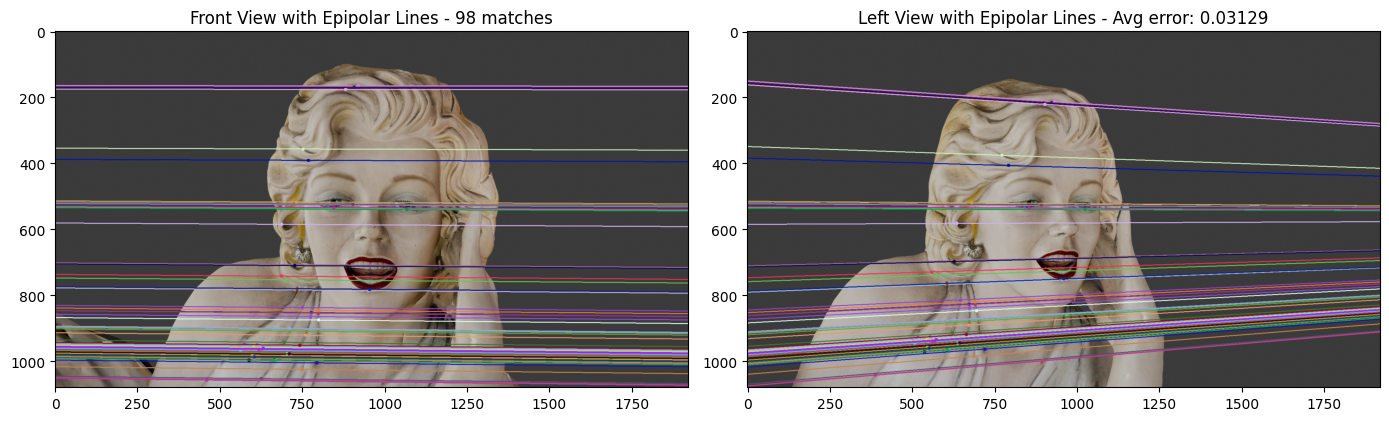

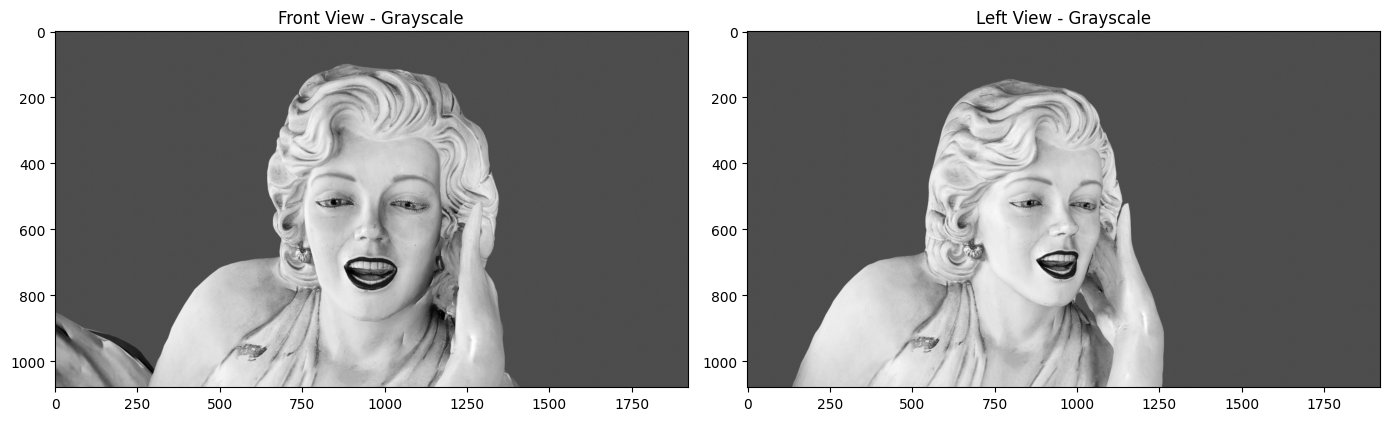

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from math import sin, cos, radians
from scipy.spatial.distance import cdist


def compute_fundamental_matrix(K1, K2, R, t):
    """
    Compute the fundamental matrix from camera intrinsics and relative pose.

    Parameters:
    K1, K2: 3x3 intrinsic camera matrices for both cameras
    R: 3x3 rotation matrix (camera 2 relative to camera 1)
    t: 3x1 translation vector (camera 2 relative to camera 1)

    Returns:
    F: 3x3 fundamental matrix
    """
    # Create the essential matrix
    t_x = np.array([[0, -t[2], t[1]], [t[2], 0, -t[0]], [-t[1], t[0], 0]])
    E = t_x @ R

    # Compute the fundamental matrix
    F = np.linalg.inv(K2).T @ E @ np.linalg.inv(K1)

    # Normalize F
    F = F / np.linalg.norm(F)

    # Enforce rank 2 constraint
    U, S, V = np.linalg.svd(F)
    S[2] = 0  # Force the smallest singular value to be zero
    F = U @ np.diag(S) @ V

    return F


def compute_epipolar_lines(F, points, image_shape, which_image="first"):
    """
    Compute epipolar lines in one image from points in the other image.

    Parameters:
    F: Fundamental matrix
    points: Nx2 array of points
    image_shape: (height, width) of the image
    which_image: 'first' or 'second' - indicates which image contains the points

    Returns:
    lines: Nx3 array of line parameters (a, b, c) where ax + by + c = 0
    """
    points_homogeneous = np.hstack((points, np.ones((len(points), 1))))

    if which_image == "first":
        # Points in the first image, compute lines in the second
        lines = (F @ points_homogeneous.T).T
    else:
        # Points in the second image, compute lines in the first
        lines = (F.T @ points_homogeneous.T).T

    # Normalize the lines
    for i in range(len(lines)):
        norm = np.sqrt(lines[i][0] ** 2 + lines[i][1] ** 2)
        if norm > 1e-8:  # Avoid division by zero
            lines[i] = lines[i] / norm

    return lines


def point_to_line_distance(point, line):
    """
    Calculate the distance from a point to a line.

    Parameters:
    point: [x, y] coordinates
    line: Line parameters [a, b, c] where ax + by + c = 0

    Returns:
    distance: Perpendicular distance from point to line
    """
    x, y = point
    a, b, c = line
    return abs(a * x + b * y + c) / np.sqrt(a**2 + b**2)


def find_epipole(F):
    """
    Find the epipole from the fundamental matrix.
    The epipole is the null space of F (or F.T).

    Parameters:
    F: Fundamental matrix

    Returns:
    e1, e2: Epipoles in homogeneous coordinates
    """
    # Find the epipole in the second image (right null space of F)
    _, _, V = np.linalg.svd(F)
    e2 = V[-1]
    if abs(e2[2]) > 1e-8:  # Check if the last component is not too close to zero
        e2 = e2 / e2[2]  # Normalize to homogeneous coordinates

    # Find the epipole in the first image (right null space of F.T)
    _, _, V = np.linalg.svd(F.T)
    e1 = V[-1]
    if abs(e1[2]) > 1e-8:
        e1 = e1 / e1[2]

    return e1, e2


def draw_epipolar_lines(img1, img2, F, pts1, pts2, line_thickness=1):
    """
    Draw epipolar lines on both images.

    Parameters:
    img1, img2: Input images
    F: Fundamental matrix
    pts1, pts2: Corresponding points in both images
    line_thickness: Thickness of the epipolar lines

    Returns:
    img1_lines, img2_lines: Images with epipolar lines drawn
    """
    img1_copy = img1.copy()
    img2_copy = img2.copy()

    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Calculate epipolar lines in the second image corresponding to points in the first
    lines2 = compute_epipolar_lines(F, pts1, (h2, w2), "first")

    # Calculate epipolar lines in the first image corresponding to points in the second
    lines1 = compute_epipolar_lines(F, pts2, (h1, w1), "second")

    # Generate random colors for each point pair
    colors = np.random.randint(0, 255, (len(pts1), 3))

    # Compute the error for each match (Sampson distance)
    errors = []
    for i in range(len(pts1)):
        # Convert points to homogeneous coordinates
        p1 = np.append(pts1[i], 1)
        p2 = np.append(pts2[i], 1)

        # Compute Sampson distance
        Fp1 = F @ p1
        FTp2 = F.T @ p2
        error = (p2.T @ F @ p1) ** 2 / (
            Fp1[0] ** 2 + Fp1[1] ** 2 + FTp2[0] ** 2 + FTp2[1] ** 2
        )
        errors.append(abs(error))

    # Draw lines and points
    for i in range(len(pts1)):
        color = colors[i].tolist()

        # Draw points
        cv2.circle(img1_copy, (int(pts1[i][0]), int(pts1[i][1])), 5, color, -1)
        cv2.circle(img2_copy, (int(pts2[i][0]), int(pts2[i][1])), 5, color, -1)

        # Draw epipolar lines
        # Lines in the second image
        a, b, c = lines2[i]

        # Calculate intersection points with image borders
        if abs(b) > 1e-8:  # Not a vertical line
            # Calculate y for x=0 and x=width
            y_left = int(-c / b)
            y_right = int(-(a * w2 + c) / b)

            # Check if intersection points are within image boundaries
            points = []
            if 0 <= y_left < h2:
                points.append((0, y_left))
            if 0 <= y_right < h2:
                points.append((w2 - 1, y_right))

            # Calculate x for y=0 and y=height
            x_top = int(-c / a) if abs(a) > 1e-8 else w2 // 2
            x_bottom = int(-(b * h2 + c) / a) if abs(a) > 1e-8 else w2 // 2

            if 0 <= x_top < w2:
                points.append((x_top, 0))
            if 0 <= x_bottom < w2:
                points.append((x_bottom, h2 - 1))

            # Draw line if we have at least 2 valid intersection points
            if len(points) >= 2:
                cv2.line(img2_copy, points[0], points[1], color, line_thickness)
        else:  # Vertical line
            x = int(-c / a) if abs(a) > 1e-8 else 0
            if 0 <= x < w2:
                cv2.line(img2_copy, (x, 0), (x, h2 - 1), color, line_thickness)

        # Lines in the first image (similar approach)
        a, b, c = lines1[i]

        # Calculate intersection points with image borders
        if abs(b) > 1e-8:  # Not a vertical line
            # Calculate y for x=0 and x=width
            y_left = int(-c / b)
            y_right = int(-(a * w1 + c) / b)

            # Check if intersection points are within image boundaries
            points = []
            if 0 <= y_left < h1:
                points.append((0, y_left))
            if 0 <= y_right < h1:
                points.append((w1 - 1, y_right))

            # Calculate x for y=0 and y=height
            x_top = int(-c / a) if abs(a) > 1e-8 else w1 // 2
            x_bottom = int(-(b * h1 + c) / a) if abs(a) > 1e-8 else w1 // 2

            if 0 <= x_top < w1:
                points.append((x_top, 0))
            if 0 <= x_bottom < w1:
                points.append((x_bottom, h1 - 1))

            # Draw line if we have at least 2 valid intersection points
            if len(points) >= 2:
                cv2.line(img1_copy, points[0], points[1], color, line_thickness)
        else:  # Vertical line
            x = int(-c / a) if abs(a) > 1e-8 else 0
            if 0 <= x < w1:
                cv2.line(img1_copy, (x, 0), (x, h1 - 1), color, line_thickness)

    # Return images with epipolar lines and the average error
    avg_error = np.mean(errors) if errors else 0
    return img1_copy, img2_copy, avg_error


def find_matches_with_descriptors(img1, img2, max_matches=50):
    """
    Find feature matches between two images using SIFT descriptors and ratio test.

    Parameters:
    img1, img2: Input grayscale images
    max_matches: Maximum number of matches to return

    Returns:
    pts1, pts2: Matched point coordinates in both images
    """
    # Detect SIFT features and compute descriptors
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Match descriptors using FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Sort matches by distance and take the best ones
    good_matches = sorted(good_matches, key=lambda x: x.distance)
    if max_matches > 0:
        good_matches = good_matches[:max_matches]

    # Extract matched point coordinates
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

    return pts1, pts2


def find_fundamental_matrix_ransac(pts1, pts2, ransac_threshold=1.0):
    """
    Estimate the fundamental matrix using RANSAC to handle outliers.

    Parameters:
    pts1, pts2: Matched point coordinates in both images
    ransac_threshold: Distance threshold for RANSAC

    Returns:
    F: Fundamental matrix
    mask: Inlier mask
    """
    # Estimate fundamental matrix using RANSAC
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransac_threshold, 0.99)

    # Check if F is valid
    if F is None or F.shape != (3, 3):
        return None, None

    # Enforce rank 2 constraint
    U, S, V = np.linalg.svd(F)
    S[2] = 0  # Force the smallest singular value to be zero
    F = U @ np.diag(S) @ V

    return F, mask


def refine_matches_with_epipolar(pts1, pts2, F, threshold=1.0):
    """
    Refine matches by filtering points based on epipolar constraint.

    Parameters:
    pts1, pts2: Matched point coordinates in both images
    F: Fundamental matrix
    threshold: Maximum allowed epipolar distance

    Returns:
    refined_pts1, refined_pts2: Filtered point coordinates
    """
    # Convert points to homogeneous coordinates
    pts1_hom = np.hstack((pts1, np.ones((len(pts1), 1))))
    pts2_hom = np.hstack((pts2, np.ones((len(pts2), 1))))

    # Calculate epipolar lines in the second image
    lines2 = (F @ pts1_hom.T).T

    # Calculate distances from points to their corresponding epipolar lines
    distances = []
    for i in range(len(pts2)):
        # Normalize the line
        line = lines2[i]
        norm = np.sqrt(line[0] ** 2 + line[1] ** 2)
        if norm > 1e-8:
            line = line / norm

        # Calculate distance from point to line
        distance = abs(np.sum(line * pts2_hom[i]))
        distances.append(distance)

    # Filter points based on the epipolar constraint
    distances = np.array(distances)
    inliers = distances < threshold

    return pts1[inliers], pts2[inliers]


def find_epipolar_correspondences_improved(img1, img2, K1, K2, R, t, num_points=100):
    """
    Find accurate epipolar correspondences between two images.

    Parameters:
    img1, img2: Input grayscale images
    K1, K2: Camera intrinsic matrices
    R, t: Rotation and translation from camera 1 to camera 2
    num_points: Number of points to detect

    Returns:
    pts1, pts2: Corresponding points in both images
    F: Estimated fundamental matrix
    """
    # Method 1: Use theoretical F from camera parameters
    F_theoretical = compute_fundamental_matrix(K1, K2, R, t)

    # Method 2: Find matches using feature descriptors
    pts1, pts2 = find_matches_with_descriptors(img1, img2, num_points)

    if len(pts1) < 8:
        print("Not enough matches found!")
        return None, None, F_theoretical

    # Method 3: Estimate F using RANSAC on the matched points
    F_estimated, mask = find_fundamental_matrix_ransac(pts1, pts2)

    if F_estimated is None:
        print("Failed to estimate fundamental matrix from points!")
        # Use theoretical F and refine matches
        pts1_refined, pts2_refined = refine_matches_with_epipolar(
            pts1, pts2, F_theoretical
        )
        return pts1_refined, pts2_refined, F_theoretical

    # Get inliers from RANSAC
    mask = mask.ravel().astype(bool)
    pts1_inliers = pts1[mask]
    pts2_inliers = pts2[mask]

    # Final refinement using the estimated F
    pts1_refined, pts2_refined = refine_matches_with_epipolar(
        pts1_inliers, pts2_inliers, F_estimated
    )

    # Choose the best F: theoretical or estimated
    # For this example, we'll use the estimated F if it has enough inliers
    if len(pts1_refined) >= 8:
        return pts1_refined, pts2_refined, F_estimated
    else:
        # Fall back to theoretical F
        pts1_refined, pts2_refined = refine_matches_with_epipolar(
            pts1, pts2, F_theoretical
        )
        return pts1_refined, pts2_refined, F_theoretical


def create_rotation_matrix_z(degrees):
    """
    Create a 3x3 rotation matrix for a rotation around the Z-axis.

    Parameters:
    degrees: Rotation angle in degrees

    Returns:
    R: 3x3 rotation matrix
    """
    theta = radians(degrees)
    return np.array(
        [[cos(theta), -sin(theta), 0], [sin(theta), cos(theta), 0], [0, 0, 1]]
    )


# Example of usage with Blender camera parameters
def main():
    # Load sample images
    img1 = cv2.imread("front.png")
    img2 = cv2.imread("left.png")

    if img1 is None or img2 is None:
        print("Could not load images!")
        return

    # Blender camera settings as provided
    focal_length_mm = 50  # in mm
    sensor_width_mm = 36  # in mm (default full-frame)
    image_width_px = 1920
    image_height_px = 1080

    # Convert focal length to pixels
    fx = focal_length_mm * (image_width_px / sensor_width_mm)
    fy = fx  # square pixels assumed

    # Principal point (assuming center of image)
    cx = image_width_px / 2
    cy = image_height_px / 2

    # Camera intrinsic matrix K for the first camera
    K1 = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], dtype=np.float64)

    # For the second camera (same intrinsics)
    K2 = K1.copy()

    # Second camera is translated by -0.5m along X-axis and rotated by -30 degrees around Z-axis
    # Rotation matrix for -30 degrees around Z-axis
    R = create_rotation_matrix_z(-30)

    # Translation vector (-0.5m along X-axis)
    t = np.array([-0.5, 0, 0])

    # Find epipolar correspondences using the improved method
    pts1, pts2, F = find_epipolar_correspondences_improved(gray1, gray2, K1, K2, R, t)

    if pts1 is None or len(pts1) < 8:
        print("Not enough reliable correspondences found!")
        return

    # Draw epipolar lines and calculate average error
    img1_lines, img2_lines, avg_error = draw_epipolar_lines(
        img1, img2, F, pts1, pts2, line_thickness=2
    )

    # Display results
    plt.figure(figsize=(14, 7))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img1_lines, cv2.COLOR_BGR2RGB))
    plt.title(f"Front View with Epipolar Lines - {len(pts1)} matches")
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(img2_lines, cv2.COLOR_BGR2RGB))
    plt.title(f"Left View with Epipolar Lines - Avg error: {avg_error:.5f}")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

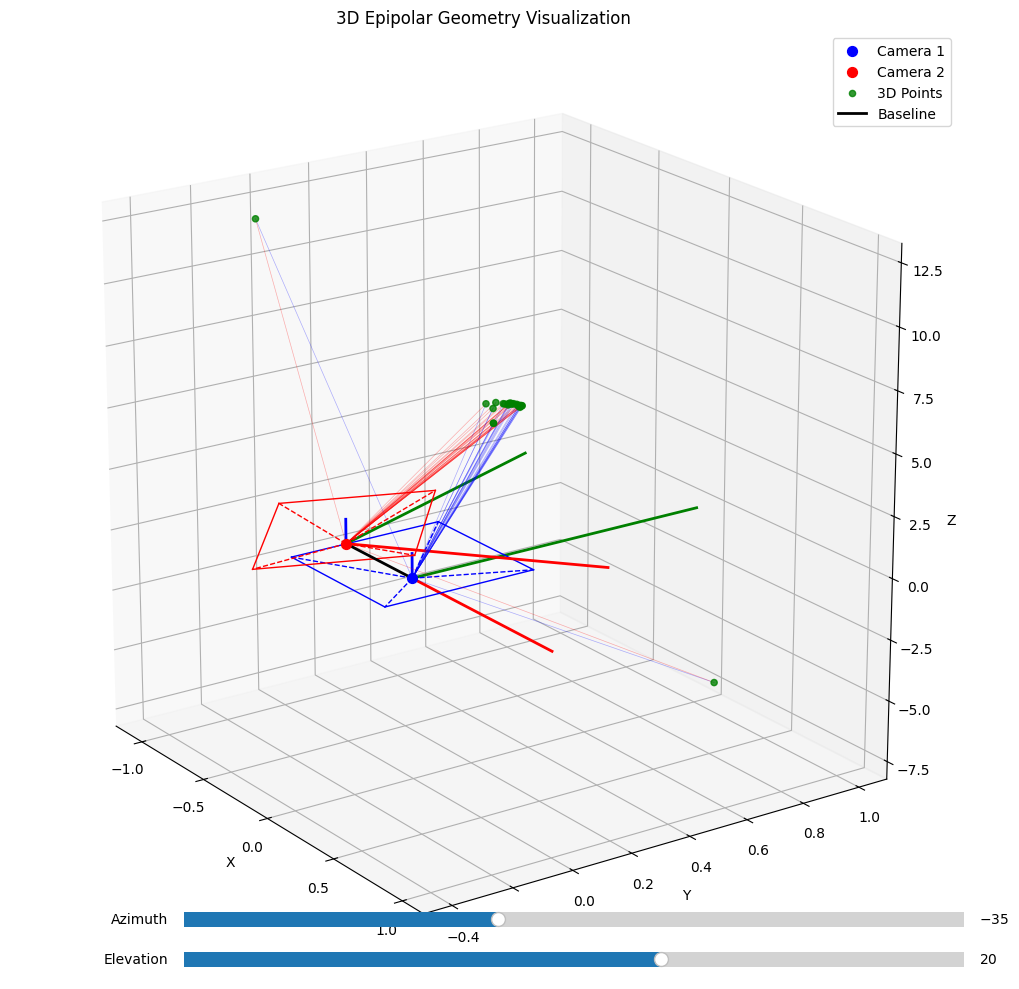

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider
import cv2
from math import sin, cos, radians


def compute_fundamental_matrix(K1, K2, R, t):
    """
    Compute the fundamental matrix from camera intrinsics and relative pose.
    """
    t_x = np.array([[0, -t[2], t[1]], [t[2], 0, -t[0]], [-t[1], t[0], 0]])
    E = t_x @ R

    F = np.linalg.inv(K2).T @ E @ np.linalg.inv(K1)
    F = F / np.linalg.norm(F)

    # Enforce rank 2 constraint
    U, S, V = np.linalg.svd(F)
    S[2] = 0
    F = U @ np.diag(S) @ V

    return F


def create_rotation_matrix_z(degrees):
    """
    Create a 3x3 rotation matrix for a rotation around the Z-axis.
    """
    theta = radians(degrees)
    return np.array(
        [[cos(theta), -sin(theta), 0], [sin(theta), cos(theta), 0], [0, 0, 1]]
    )


def triangulate_points(pts1, pts2, P1, P2):
    """
    Triangulate 3D points from corresponding 2D points in two images.

    Parameters:
    pts1, pts2: Nx2 arrays of corresponding points
    P1, P2: 3x4 camera projection matrices

    Returns:
    points_3d: Nx3 array of triangulated 3D points
    """
    points_3d = []

    for pt1, pt2 in zip(pts1, pts2):
        # Convert to homogeneous coordinates
        x1, y1 = pt1
        x2, y2 = pt2

        # Build the system of equations
        A = np.zeros((4, 4))
        A[0] = x1 * P1[2] - P1[0]
        A[1] = y1 * P1[2] - P1[1]
        A[2] = x2 * P2[2] - P2[0]
        A[3] = y2 * P2[2] - P2[1]

        # Solve for the 3D point using SVD
        _, _, Vt = np.linalg.svd(A)
        X = Vt[-1]

        # Convert from homogeneous to Euclidean coordinates
        X = X / X[3]
        points_3d.append(X[:3])

    return np.array(points_3d)


def get_camera_params_from_P(P):
    """
    Extract camera parameters from a projection matrix.

    Parameters:
    P: 3x4 camera projection matrix

    Returns:
    K: 3x3 camera intrinsic matrix
    R: 3x3 rotation matrix
    t: 3x1 translation vector
    """
    # Extract camera center
    M = P[:, :3]
    p4 = P[:, 3]

    # Camera center C = -M^-1 * p4
    C = -np.linalg.inv(M) @ p4

    # Decompose M into K*R using RQ decomposition
    K, R = np.linalg.qr(M)
    K = np.flip(K, axis=0)
    K = np.flip(K, axis=1)
    R = np.flip(R, axis=0)
    R = np.flip(R, axis=1)
    R = R.T

    # Make sure K has positive diagonal
    T = np.diag(np.sign(np.diag(K)))
    K = K @ T
    R = T @ R

    # Normalize K
    K = K / K[2, 2]

    return K, R, C


def draw_camera(ax, R, t, scale=0.5, color="b", label=None):
    """
    Draw a camera in a 3D plot.

    Parameters:
    ax: Matplotlib 3D axis
    R: 3x3 rotation matrix
    t: 3x1 translation vector
    scale: Size of the camera
    color: Color of the camera
    label: Label for the camera
    """
    # Camera center
    cam_center = t

    # Camera axes
    axis_length = scale
    x_axis = cam_center + axis_length * R[0]
    y_axis = cam_center + axis_length * R[1]
    z_axis = cam_center + axis_length * R[2]

    # Draw camera center
    ax.scatter(
        cam_center[0], cam_center[1], cam_center[2], color=color, s=50, label=label
    )

    # Draw camera axes
    ax.plot(
        [cam_center[0], x_axis[0]],
        [cam_center[1], x_axis[1]],
        [cam_center[2], x_axis[2]],
        color="r",
        linewidth=2,
    )  # x-axis (red)
    ax.plot(
        [cam_center[0], y_axis[0]],
        [cam_center[1], y_axis[1]],
        [cam_center[2], y_axis[2]],
        color="g",
        linewidth=2,
    )  # y-axis (green)
    ax.plot(
        [cam_center[0], z_axis[0]],
        [cam_center[1], z_axis[1]],
        [cam_center[2], z_axis[2]],
        color="b",
        linewidth=2,
    )  # z-axis (blue)

    # Draw camera pyramid
    width = scale * 0.7
    height = scale * 0.5
    depth = scale * 0.6

    # Calculate the corners of the image plane in camera coordinates
    corners = np.array(
        [
            [-width / 2, -height / 2, depth],  # Bottom-left
            [width / 2, -height / 2, depth],  # Bottom-right
            [width / 2, height / 2, depth],  # Top-right
            [-width / 2, height / 2, depth],  # Top-left
            [0, 0, 0],  # Camera center
        ]
    )

    # Transform to world coordinates
    corners_world = []
    for corner in corners:
        world_corner = cam_center + R @ corner
        corners_world.append(world_corner)
    corners_world = np.array(corners_world)

    # Draw the camera pyramid
    # Image plane
    ax.plot(
        [corners_world[0, 0], corners_world[1, 0]],
        [corners_world[0, 1], corners_world[1, 1]],
        [corners_world[0, 2], corners_world[1, 2]],
        color=color,
        linewidth=1,
    )
    ax.plot(
        [corners_world[1, 0], corners_world[2, 0]],
        [corners_world[1, 1], corners_world[2, 1]],
        [corners_world[1, 2], corners_world[2, 2]],
        color=color,
        linewidth=1,
    )
    ax.plot(
        [corners_world[2, 0], corners_world[3, 0]],
        [corners_world[2, 1], corners_world[3, 1]],
        [corners_world[2, 2], corners_world[3, 2]],
        color=color,
        linewidth=1,
    )
    ax.plot(
        [corners_world[3, 0], corners_world[0, 0]],
        [corners_world[3, 1], corners_world[0, 1]],
        [corners_world[3, 2], corners_world[0, 2]],
        color=color,
        linewidth=1,
    )

    # Connecting lines from center to image plane
    for i in range(4):
        ax.plot(
            [corners_world[4, 0], corners_world[i, 0]],
            [corners_world[4, 1], corners_world[i, 1]],
            [corners_world[4, 2], corners_world[i, 2]],
            color=color,
            linewidth=1,
            linestyle="--",
        )


def find_matches_with_descriptors(img1, img2, max_matches=50):
    """
    Find feature matches between two images using SIFT descriptors and ratio test.
    """
    # Detect SIFT features and compute descriptors
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Match descriptors using FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Sort matches by distance and take the best ones
    good_matches = sorted(good_matches, key=lambda x: x.distance)
    if max_matches > 0:
        good_matches = good_matches[:max_matches]

    # Extract matched point coordinates
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

    return pts1, pts2, good_matches, kp1, kp2


def find_fundamental_matrix_ransac(pts1, pts2, ransac_threshold=1.0):
    """
    Estimate the fundamental matrix using RANSAC to handle outliers.
    """
    # Estimate fundamental matrix using RANSAC
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransac_threshold, 0.99)

    # Check if F is valid
    if F is None or F.shape != (3, 3):
        return None, None

    # Enforce rank 2 constraint
    U, S, V = np.linalg.svd(F)
    S[2] = 0  # Force the smallest singular value to be zero
    F = U @ np.diag(S) @ V

    return F, mask


def plot_epipolar_geometry_3d(pts1, pts2, K1, K2, R_rel, t_rel, img1=None, img2=None):
    """
    Create an interactive 3D plot of the epipolar geometry with cameras,
    epipolar lines, and triangulated points.

    Parameters:
    pts1, pts2: Corresponding points in both images
    K1, K2: Camera intrinsic matrices
    R_rel, t_rel: Relative pose from camera 1 to camera 2
    img1, img2: Optional images to show as thumbnails
    """
    # Define camera poses
    # First camera at origin with identity rotation
    R1 = np.eye(3)
    t1 = np.zeros(3)

    # Second camera position based on relative pose
    R2 = R_rel
    t2 = t_rel

    # Create camera projection matrices
    P1 = K1 @ np.hstack((R1, t1.reshape(3, 1)))
    P2 = K2 @ np.hstack((R2, t2.reshape(3, 1)))

    # Triangulate 3D points
    points_3d = triangulate_points(pts1, pts2, P1, P2)

    # Create figure and 3D axis
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection="3d")

    # Draw cameras
    draw_camera(ax, R1, t1, scale=1.0, color="blue", label="Camera 1")
    draw_camera(ax, R2, t2, scale=1.0, color="red", label="Camera 2")

    # Plot 3D points
    ax.scatter(
        points_3d[:, 0],
        points_3d[:, 1],
        points_3d[:, 2],
        c="green",
        s=20,
        alpha=0.8,
        label="3D Points",
    )

    # Draw epipolar lines in 3D
    # These are lines from camera centers through the 3D points
    for point in points_3d:
        # Line from camera 1 to point
        ax.plot(
            [t1[0], point[0]],
            [t1[1], point[1]],
            [t1[2], point[2]],
            "b-",
            alpha=0.3,
            linewidth=0.5,
        )
        # Line from camera 2 to point
        ax.plot(
            [t2[0], point[0]],
            [t2[1], point[1]],
            [t2[2], point[2]],
            "r-",
            alpha=0.3,
            linewidth=0.5,
        )

    # Draw the baseline between the cameras
    ax.plot(
        [t1[0], t2[0]],
        [t1[1], t2[1]],
        [t1[2], t2[2]],
        "k-",
        linewidth=2,
        label="Baseline",
    )

    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])

    # Labels and title
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3D Epipolar Geometry Visualization")

    # Add legend
    ax.legend()

    # Set initial view angle
    ax.view_init(elev=20, azim=-35)

    # Make it interactive
    plt.tight_layout()

    # Add sliders for rotation
    ax_elev = plt.axes([0.25, 0.02, 0.65, 0.03])
    ax_azim = plt.axes([0.25, 0.06, 0.65, 0.03])

    slider_elev = Slider(ax_elev, "Elevation", -90, 90, valinit=20)
    slider_azim = Slider(ax_azim, "Azimuth", -180, 180, valinit=-35)

    def update(val):
        ax.view_init(elev=slider_elev.val, azim=slider_azim.val)
        fig.canvas.draw_idle()

    slider_elev.on_changed(update)
    slider_azim.on_changed(update)

    # Show the plot
    plt.show()

    return fig, ax


def main():
    # Load images
    img1 = cv2.imread("front.png")
    img2 = cv2.imread("left.png")

    if img1 is None or img2 is None:
        print("Could not load images!")
        return

    # Convert to grayscale for feature detection
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Blender camera settings
    focal_length_mm = 50  # in mm
    sensor_width_mm = 36  # in mm (default full-frame)
    image_width_px = 1920
    image_height_px = 1080

    # Convert focal length to pixels
    fx = focal_length_mm * (image_width_px / sensor_width_mm)
    fy = fx  # square pixels assumed

    # Principal point (assuming center of image)
    cx = image_width_px / 2
    cy = image_height_px / 2

    # Camera intrinsic matrix K for the first camera
    K1 = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], dtype=np.float64)

    # For the second camera (same intrinsics)
    K2 = K1.copy()

    # Second camera is translated by -0.5m along X-axis and rotated by -30 degrees around Z-axis
    # Rotation matrix for -30 degrees around Z-axis
    R_rel = create_rotation_matrix_z(-30)

    # Translation vector (-0.5m along X-axis)
    t_rel = np.array([-0.5, 0, 0])

    # Find matches between images
    pts1, pts2, _, _, _ = find_matches_with_descriptors(gray1, gray2, max_matches=30)

    if len(pts1) < 8:
        print("Not enough matches found!")
        return

    # Compute fundamental matrix
    F, mask = find_fundamental_matrix_ransac(pts1, pts2)

    if F is None:
        print("Failed to compute fundamental matrix!")
        F = compute_fundamental_matrix(K1, K2, R_rel, t_rel)
    else:
        # Filter matches using the mask from RANSAC
        mask = mask.ravel().astype(bool)
        pts1 = pts1[mask]
        pts2 = pts2[mask]

    # Plot 3D epipolar geometry
    plot_epipolar_geometry_3d(pts1, pts2, K1, K2, R_rel, t_rel, img1, img2)


if __name__ == "__main__":
    main()